# Statistical Analysis 

In [28]:
#Imports
import pandas as pd
from sklearn.decomposition import IncrementalPCA
from matplotlib.pyplot import scatter
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import itertools
import pycountry_convert as pc
from scipy.stats import mannwhitneyu
from statistics import median
import matplotlib.colors
from matplotlib.ticker import PercentFormatter
from operator import itemgetter
%matplotlib inline

In [34]:
# path = '../../data/merged_data/merged_data_2020.csv.gzip'  #Modify
path = '../../data/sample.csv'  #Modify

In [35]:
sample = pd.read_csv(path)

In [32]:
df_quotes_chunks = pd.read_csv(path, chunksize = 40000, low_memory = False, compression='gzip')
samples = []
for i, chunk in enumerate(df_quotes_chunks):
    # get sample and append it to samples
    sample = chunk.sample(400)
    samples.append(sample)

FileNotFoundError: [Errno 2] No such file or directory: '../../datasample.csv'

In [18]:
sample = pd.concat(samples)
sample.drop_duplicates(inplace=True)
sample.reset_index()
sample.shape
sample.head(10)

,quoteID,sentence_count,._per_sentence,",_per_sentence",!_per_sentence,?_per_sentence,:_per_sentence,;_per_sentence,sign_per_token,punctuation_per_sentence,...,self_ratio,union_ratio,other_ratio,sentiment,date_of_birth,nationality,gender,occupation,academic_degree,religion
26698,2020-03-12-083778,1,0.0,5.00,0.0,0.0,0.0,0.0,0.138889,0.0,...,-1.000000,1.000000,-1.000000,0.000,1947.0,United States of America,Male,Politics,NaN,NaN
17710,2020-03-15-045151,1,0.0,1.00,0.0,0.0,0.0,0.0,0.047619,0.0,...,-1.000000,-1.000000,1.000000,0.000,1946.0,France,Male,Arts,NaN,NaN
24024,2020-02-06-034344,2,0.5,0.50,0.5,0.0,0.0,0.0,0.071429,1.0,...,0.500000,-1.000000,-0.500000,0.237,1987.0,United States of America,Female,Arts,NaN,Christian
36405,2020-02-13-076114,2,1.0,0.00,0.0,0.0,0.0,0.0,0.060606,1.0,...,0.000000,0.000000,0.000000,0.017,1971.0,New Zealand,Male,Politics,NaN,NaN
18381,2020-01-26-040807,1,0.0,0.00,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.457,1971.0,India,Male,Arts,NaN,Muslim
3204,2020-01-18-052913,3,1.0,1.00,0.0,0.0,0.0,0.0,0.076923,1.0,...,-0.750000,0.750000,-1.000000,0.159,1973.0,United States of America,Male,Business,NaN,NaN
16456,2020-01-29-065899,1,1.0,3.00,0.0,0.0,0.0,0.0,0.210526,1.0,...,0.000000,0.000000,-1.000000,-0.004,1991.0,United States of America,Male,Sports,NaN,NaN
25883,2020-02-18-087093,1,1.0,1.00,0.0,0.0,0.0,0.0,0.055556,1.0,...,-1.000000,-0.333333,0.333333,0.114,1958.0,Germany,Male,Sports,NaN,NaN
24140,2020-01-24-107679,4,1.0,0.75,0.0,0.0,0.0,0.0,0.125000,1.0,...,-0.428571,-0.142857,-0.428571,0.042,1970.0,United States of America,Female,Politics,NaN,Christian
5913,2020-01-21-053301,1,0.0,2.00,0.0,0.0,0.0,0.0,0.100000,0.0,...,-1.000000,-1.000000,1.000000,-0.192,1973.0,Australia,Male,Politics,NaN,NaN


In [19]:
colors = ["#AD2646","#234473","#F4D7DB","#512E3B","#126EA8","#A76662","#D09790","#331F1C"]
custom_palette = sns.set_palette(sns.color_palette(colors))

import matplotlib.colors

norm = matplotlib.colors.Normalize(-1,1)
colors = [[norm(-1.0), "#234473"],
          [norm( 1.0), "#AD2646"]]

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)
matplotlib.rcParams['font.family'] = "monospace"
matplotlib.rcParams['font.weight'] = "semibold"

In [20]:
selected_feats = [',_per_sentence', '!_per_sentence','?_per_sentence','approx_word_count', 'token_count', 'adj_per_word', 'verb_per_word', 'base_ratio', 'pres_ratio', 'past_ratio', 'pronoun_per_word', 'sentiment']
speaker_feats = ['date_of_birth', 'nationality', 'gender', 'occupation', 'academic_degree', 'religion']

In [52]:
def mean_boxplots(df,plot_by,features,order=None):
    """Plots the means of a given feature with respect to a given parameter.

    Keyword arguments:
    df -- dataframe to be analyzed
    plot_by -- list of parameters in string format to be compared
    features -- list of features in string format to be plotted
    """
    
    num = int(math.sqrt(len(features)))
    fig, axs = plt.subplots(num,num,figsize=(30, 15))
    for i,feat in enumerate(features):
        if i<num**2:
            x_idx = int(np.floor(i/num))
            y_idx = int(i%num)
            sns.boxplot(x=plot_by, y=feat, data=df, ax=axs[x_idx,y_idx], order=order,showmeans=True,
            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"})
        
    return

## Gender

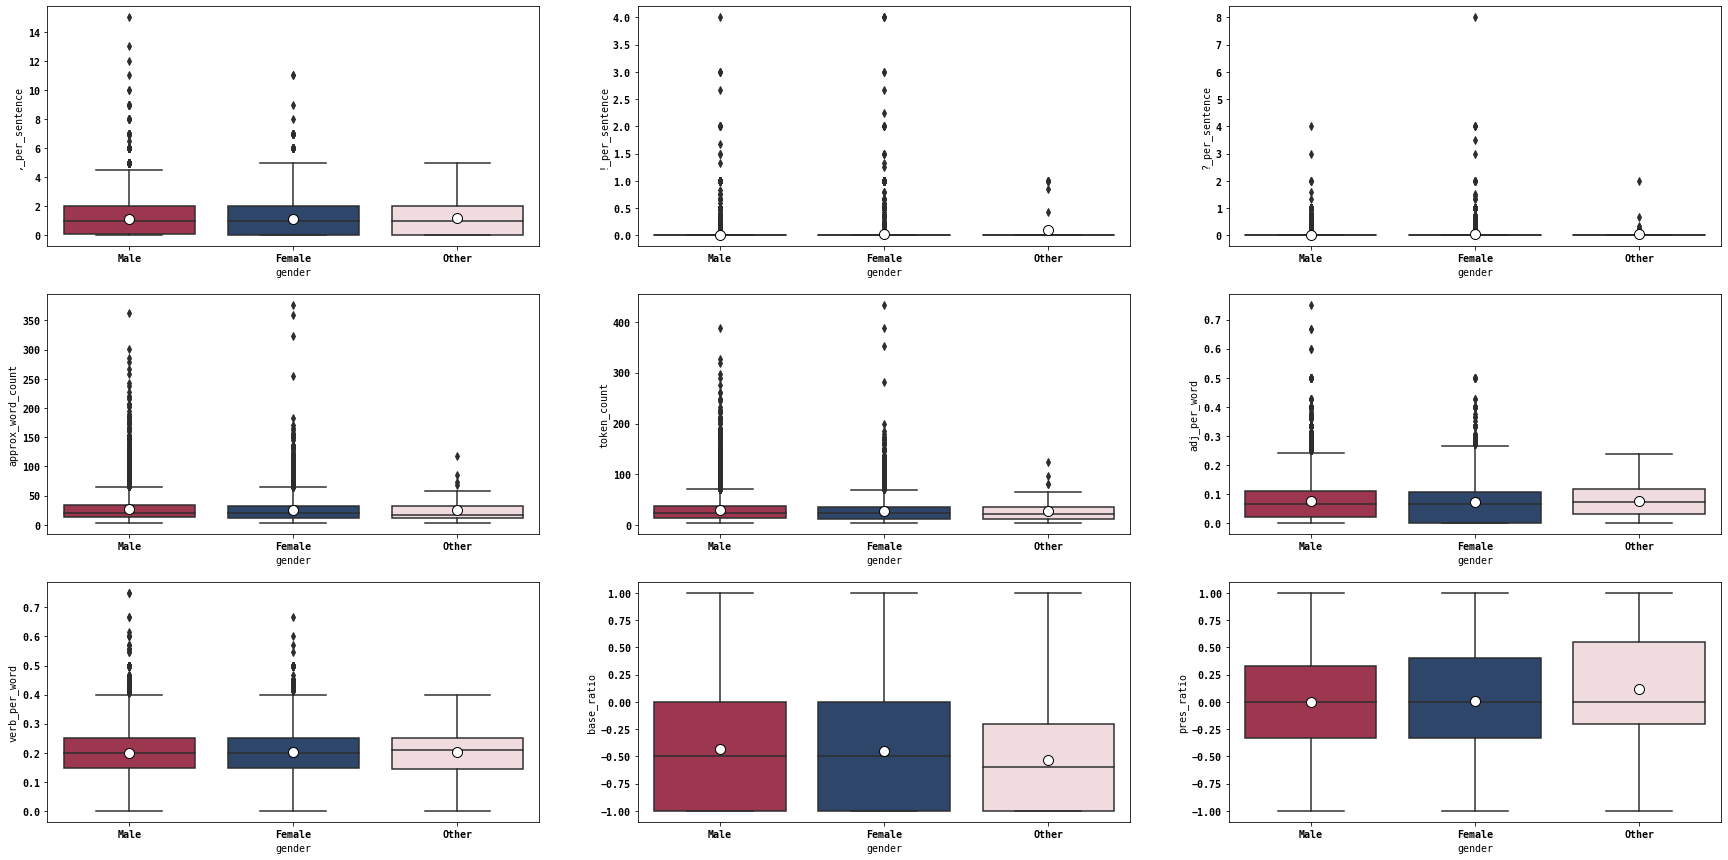

In [53]:
mean_boxplots(sample,plot_by='gender',features=selected_feats)

## Occupation

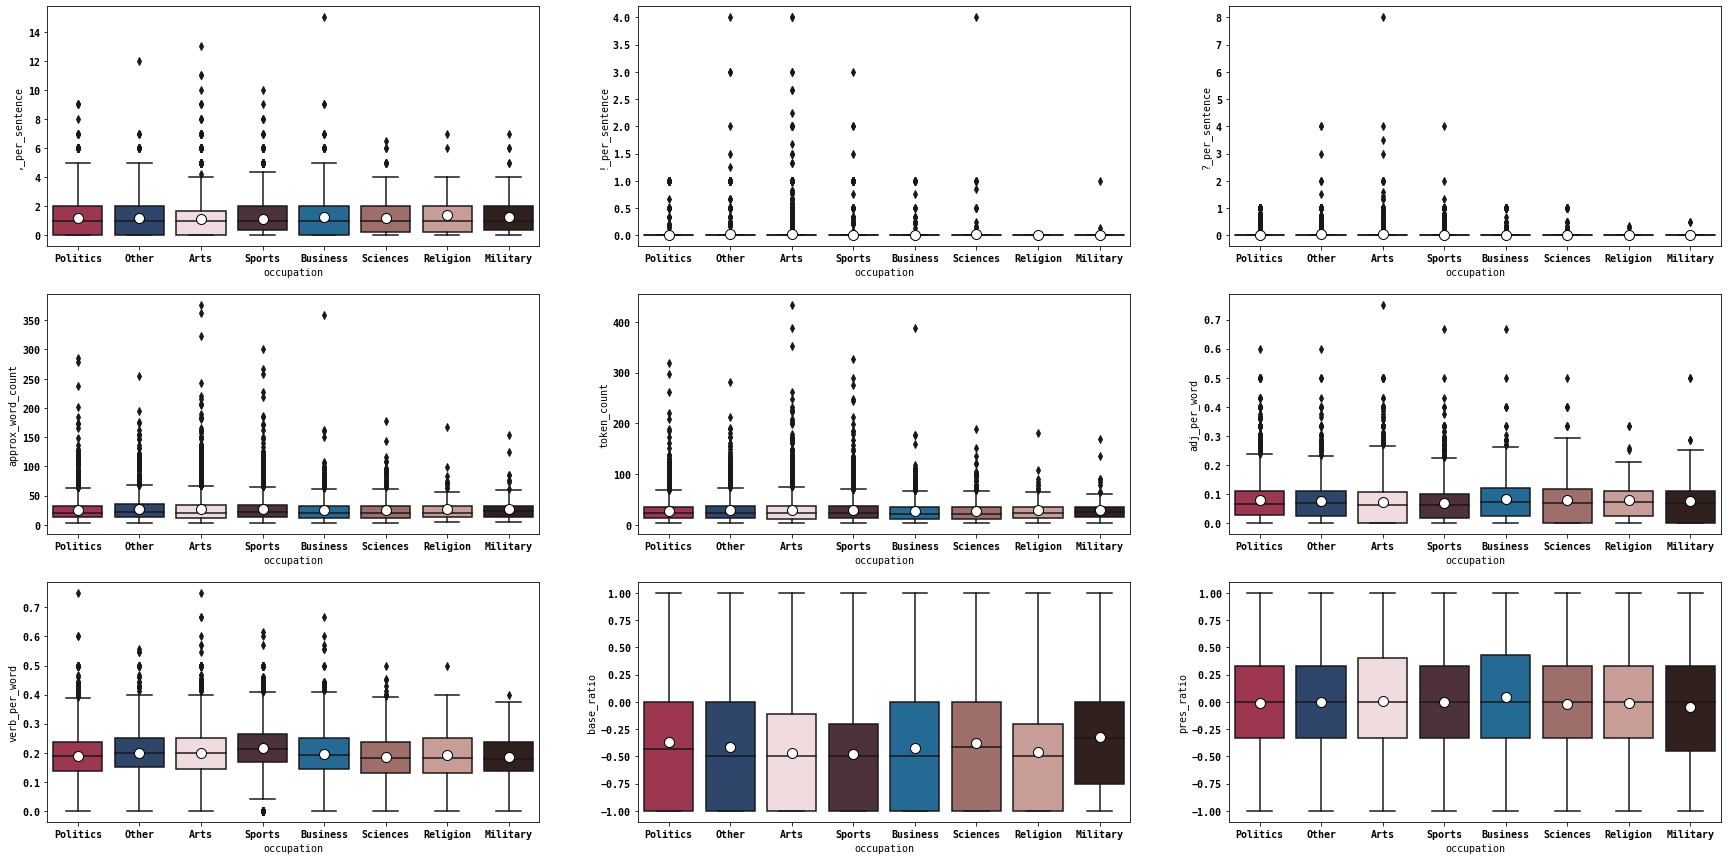

In [54]:
mean_boxplots(sample,plot_by='occupation',features=selected_feats)

## Academic Degree

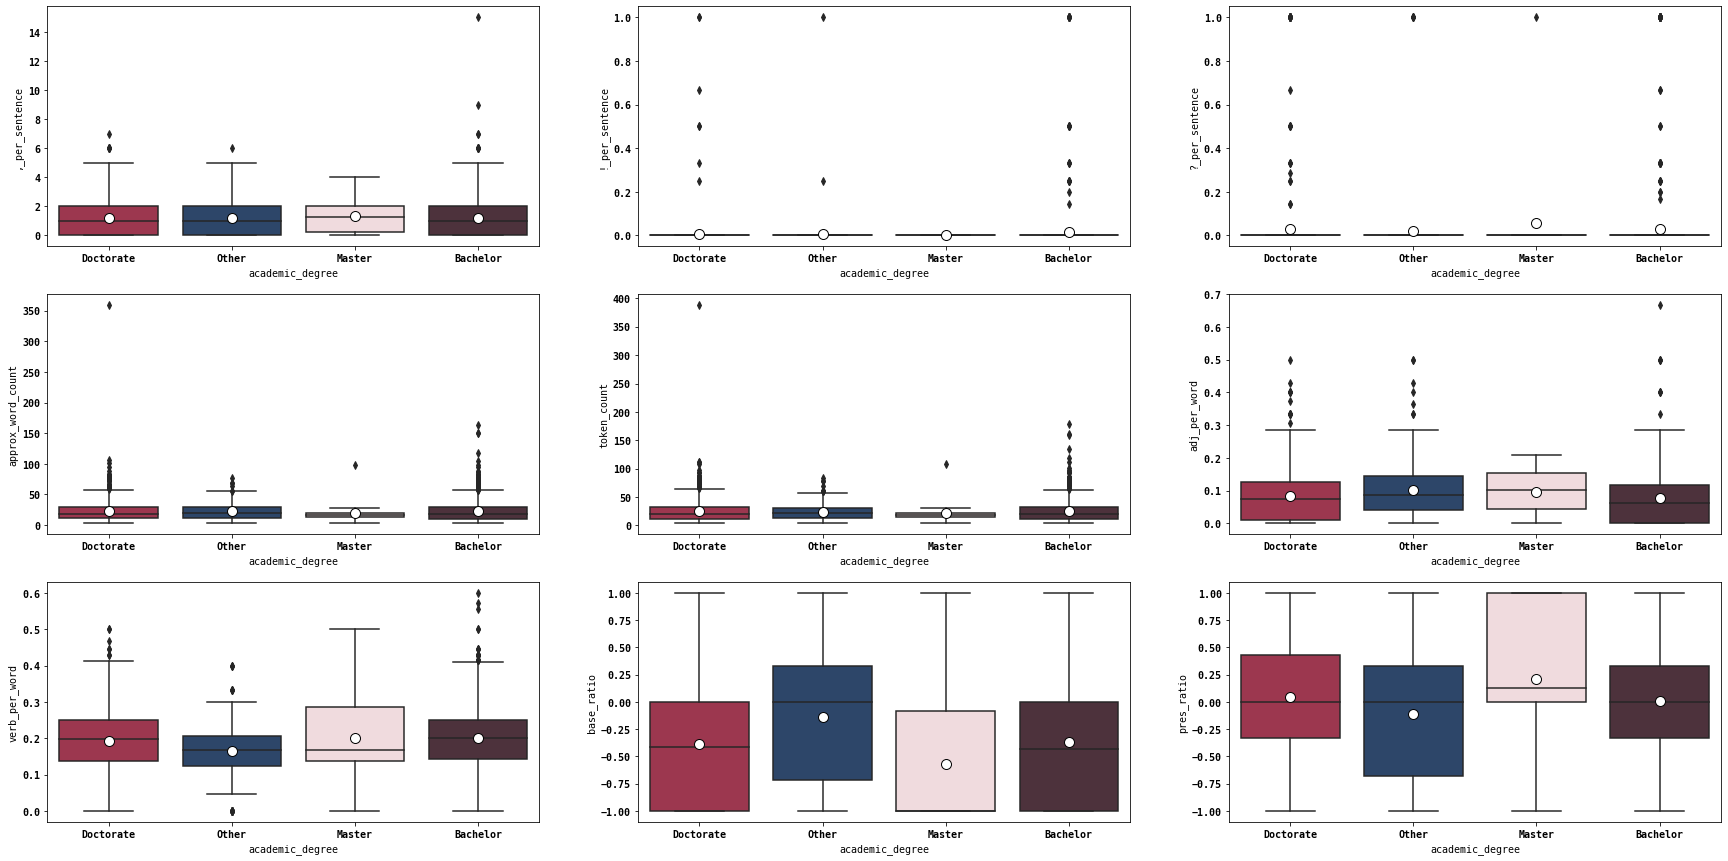

In [55]:
mean_boxplots(sample,plot_by='academic_degree',features=selected_feats)

## Religion

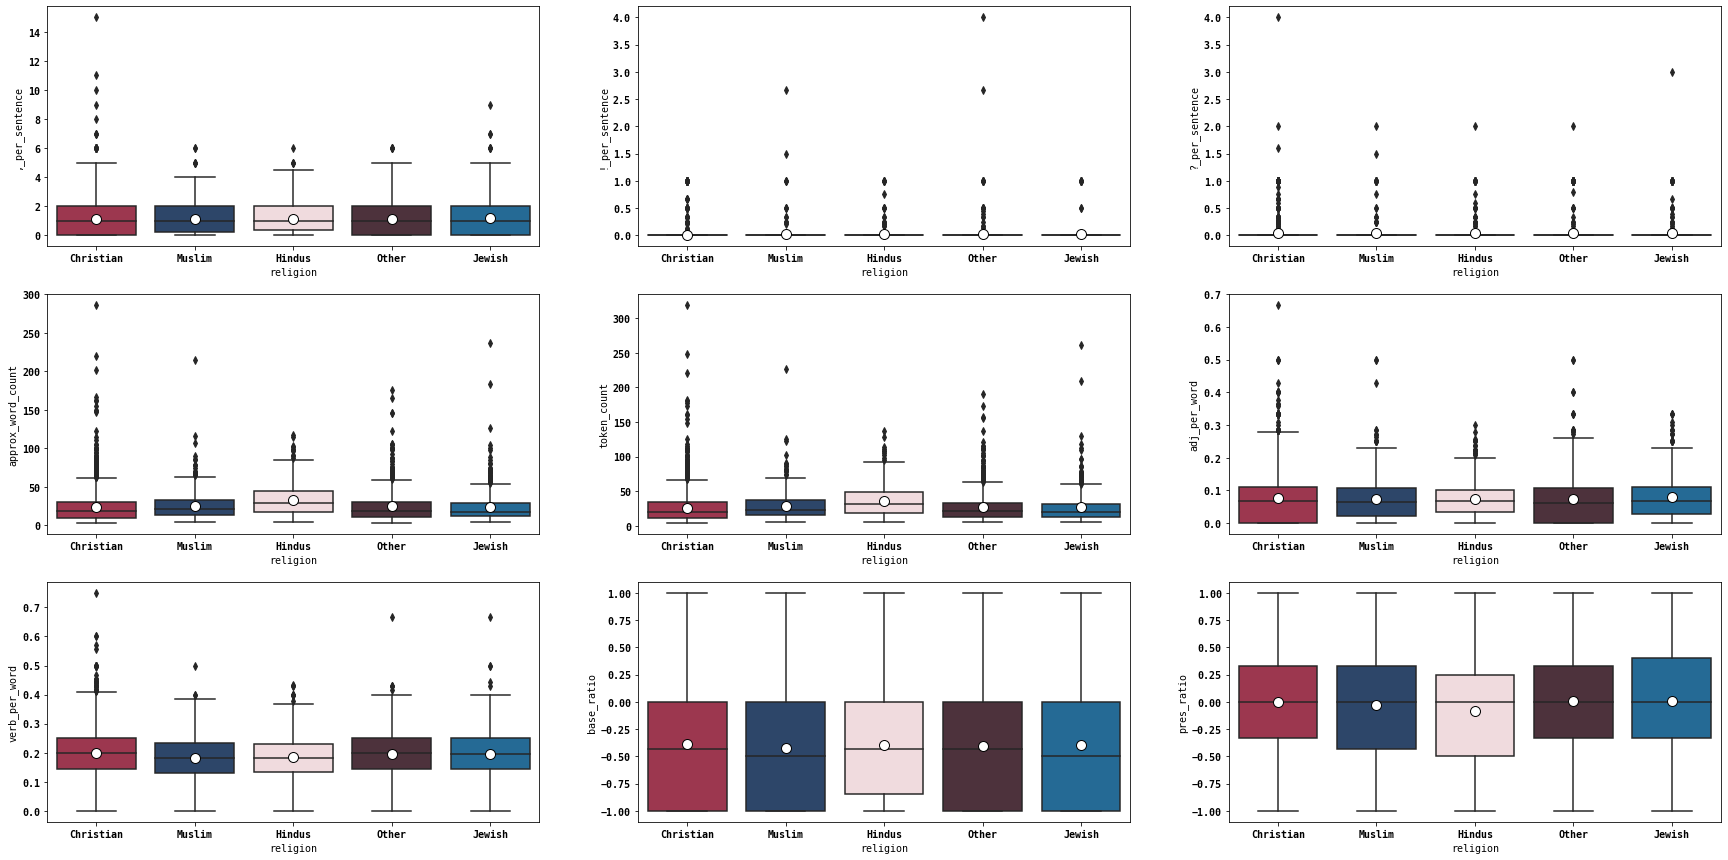

In [56]:
mean_boxplots(sample,plot_by='religion',features=selected_feats)

## Generation

In [24]:
def GroupBirthDates(sample):
    birth = sample.copy()
    birth["date_of_birth"] = birth["date_of_birth"].astype(int)
    birth["date_of_birth"] = birth["date_of_birth"].apply(lambda x: '30s' if x < 1940 else '50s' if x < 1960 else '70s' if x < 1980  else '90s' if x < 2000 else '00s' if x < 2020 else x)
    return birth

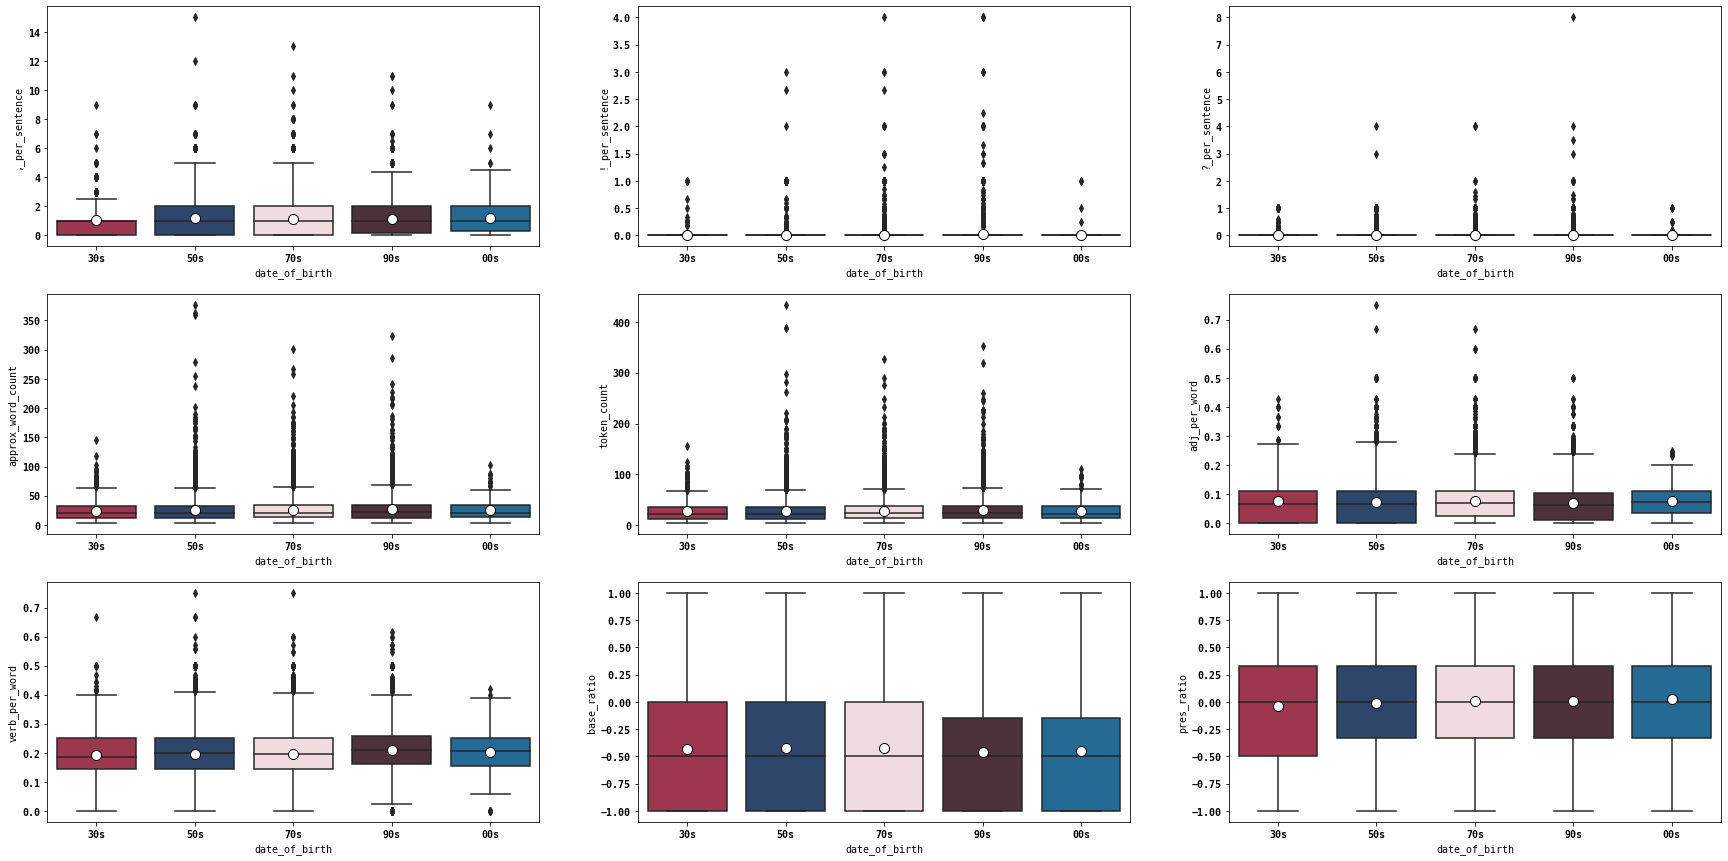

In [58]:
birth = GroupBirthDates(sample)
mean_boxplots(birth,plot_by='date_of_birth',features=selected_feats, order=["30s","50s","70s","90s","00s"])

## Continent

In [23]:
def GroupNationalities(sample):
    nat = sample.copy()
    for idx,i in enumerate(nat["nationality"]):
        try:
            nat["nationality"].iloc[idx] = pc.country_alpha2_to_continent_code(pc.country_name_to_country_alpha2(i, cn_name_format="default"))
        except:
            nat["nationality"].iloc[idx] = None
    return nat

/home/karim/anaconda3/envs/ada/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


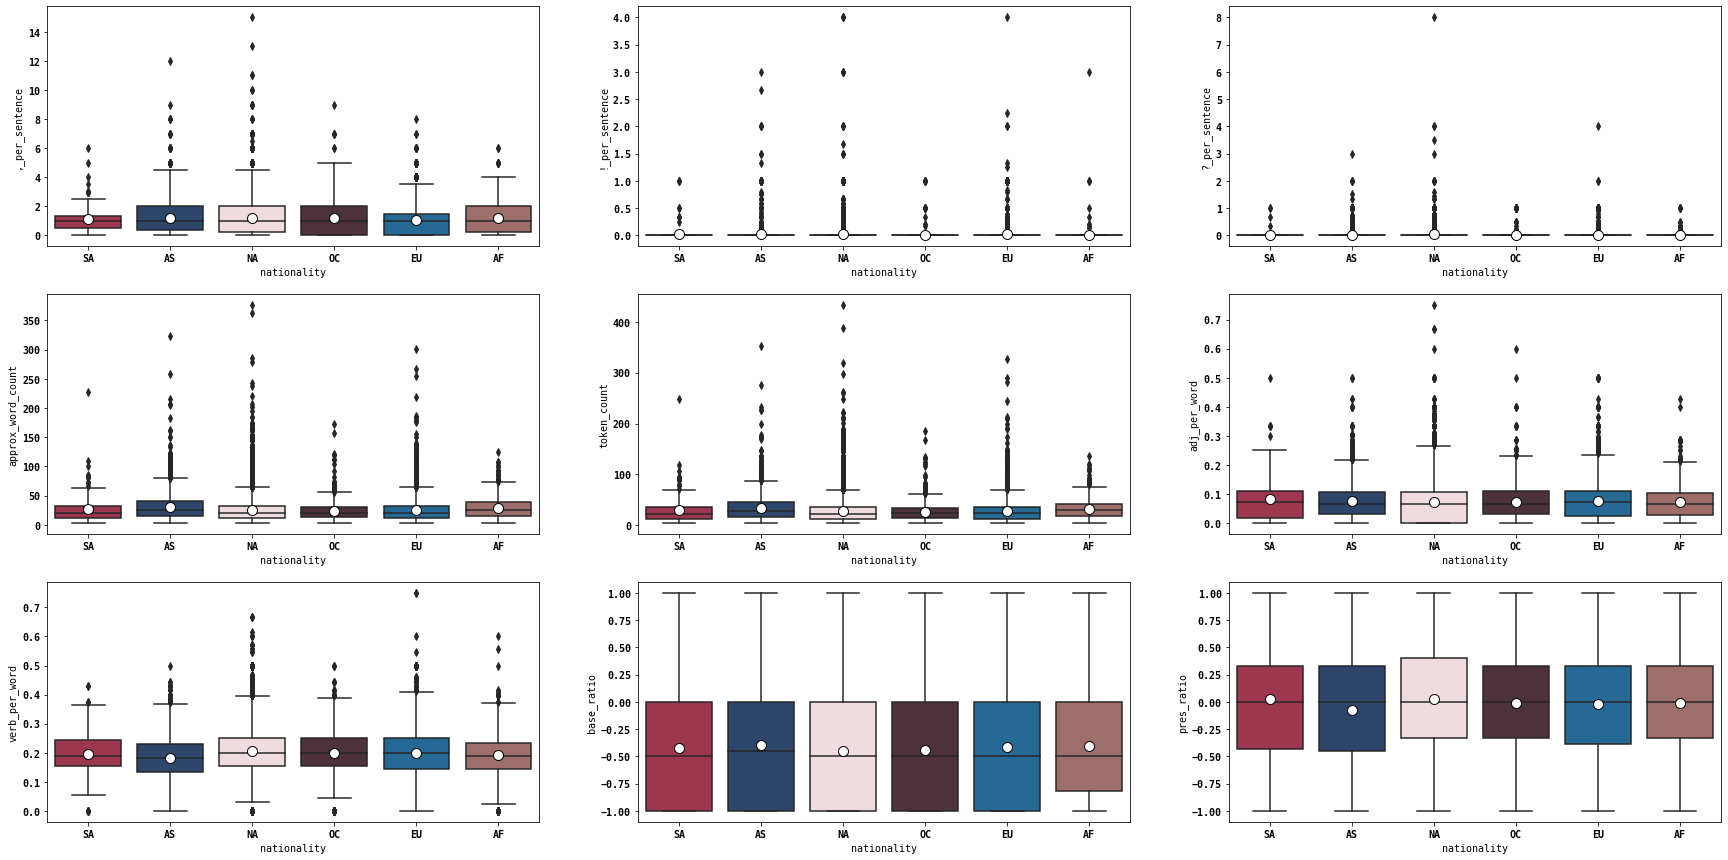

In [60]:
countries = GroupNationalities(sample)
mean_boxplots(countries,plot_by='nationality',features=selected_feats)

## Test the significance of the observed differences

In [26]:
def TestSignificance(df,lexical_features,speaker_features, tresh=0.05, verbose=False):
    Grid_max = np.zeros(shape=(len(lexical_features),len(speaker_features)))
    Grid_median = np.zeros(shape=(len(lexical_features),len(speaker_features)))
    Significant_list = []
    Significant_p =[]
    for idx_i,i in enumerate(speaker_features):                                      #Iterate over
        for idx_j,j in enumerate(lexical_features):                                  #Iterate over
            unique = df[i].unique()                  #Iterate over the different attributes
            unique = unique[unique != np.array(None)]
            unique = np.array(unique, dtype=str)
            unique = unique[unique != 'nan']
            unique = unique[unique != 'Other']
            pairs = list(itertools.combinations(unique,2))
            min_p = 1
            res = []
            for idx,k in enumerate(pairs):
                try:
                    N, p = mannwhitneyu(df[df[i]==k[0]][j], df[df[i]==k[1]][j])
                    Significant_list.append([k[0],k[1],j,i])
                    Significant_p.append(p)
                    if p < min_p:
                        min_p = p
                        min_x = k[0]
                        min_y = k[1]
                        param = j
                        speak = i
                        Grid_max[idx_j,idx_i] = 1/min_p
                    res.append(p)   
                except:
                    print('Test failed for {},{}'.format(i,j))
            if verbose:
                print('The maximum statistically significant difference with {} in {} is between {} and {}'.format(j,i,k[0],k[1]))
                print('The p-value is {}'.format(min_p))
            Grid_median[idx_j,idx_i] = 1/median(res)
    indices, Significant_p = zip(*sorted(enumerate(Significant_p), key=itemgetter(1))) #Sort the scores
    Significant_list = [Significant_list[i] for i in indices]
    return Grid_median, Grid_max, lexical_features, speaker_features, Significant_list, Significant_p

In [36]:
Test = sample.copy()
countries = GroupNationalities(sample)
birth = GroupBirthDates(sample)
Test["date_of_birth"] = birth["date_of_birth"]
Test["nationality"] = countries["nationality"]

selected_feats = ['sentence_count', '._per_sentence', ',_per_sentence', '!_per_sentence',
       '?_per_sentence', ':_per_sentence', ';_per_sentence', 'sign_per_token',
       'punctuation_per_sentence', 'approx_word_count', 'token_count',
       'adj_per_word', 'ordinal_ratio', 'comparative_ratio',
       'superlative_ratio', 'verb_per_word', 'base_ratio', 'pres_ratio',
       'past_ratio', 'pronoun_per_word', 'self_ratio', 'union_ratio',
       'other_ratio', 'sentiment']
speaker_feats = ['date_of_birth','nationality', 'gender', 'occupation', 'academic_degree', 'religion']
Grid_mean, Grid_max, lexical_features, speaker_features, Significant_list, Significant_p = TestSignificance(Test,selected_feats,speaker_feats,verbose=False)

D:\Software\anaconda\envs\ada\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in double_scalars


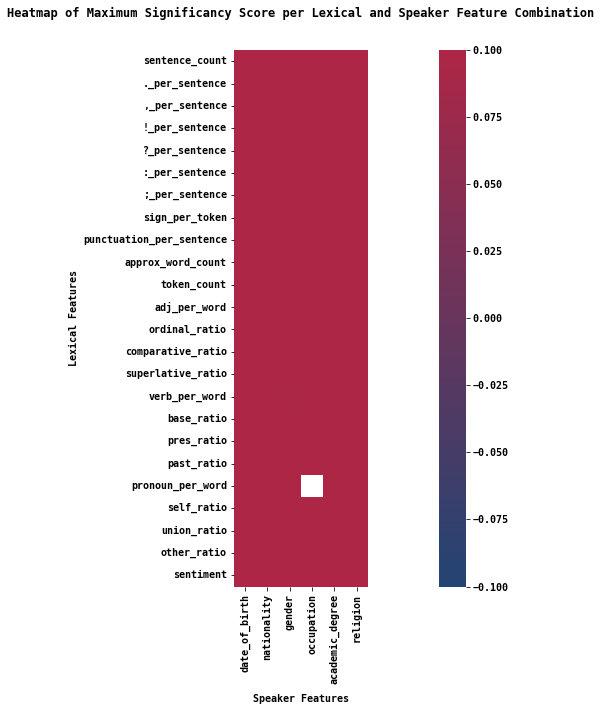

In [37]:
df = pd.DataFrame(data=np.log(Grid_max), index=selected_feats, columns=speaker_feats)
fig, ax = plt.subplots(figsize=(20,10))         # Sample figsize in inches
plt.title("Heatmap of Maximum Significancy Score per Lexical and Speaker Feature Combination", fontweight='semibold', y=1.05)
plot = sns.heatmap(df, ax=ax, cmap=cmap, square=True)
plt.xlabel('Speaker Features', fontweight='semibold')
plt.ylabel('Lexical Features', fontweight='semibold')
ax.xaxis.set_label_coords(0.5, -0.2)
plt.tight_layout()
plt.show()
plot.get_figure().savefig("Max_Significancy_Score.png",dpi=300,bbox_inches="tight")

In [ ]:
df = pd.DataFrame(data=np.log(Grid_mean), index=selected_feats, columns=speaker_feats)
setProperties()
fig, ax = plt.subplots(figsize=(20,10))         # Sample figsize in inches
plt.title("Heatmap of Median Significancy Score per Lexical and Speaker Feature Combination", fontweight='semibold',y=1.05)
plot = sns.heatmap(df, ax=ax, cmap=cmap, square=True)
plt.xlabel('Speaker Features', fontweight='semibold')
plt.ylabel('Lexical Features', fontweight='semibold')
ax.xaxis.set_label_coords(0.5, -0.2)
plt.tight_layout()
plt.show()
plot.get_figure().savefig("Median_Significancy_Score.png",dpi=300,bbox_inches="tight")

## Plot the distributions

In [150]:
def setProperties():
    colors = ["#AD2646","#234473","#F4D7DB","#512E3B","#126EA8","#A76662","#D09790","#331F1C"]
    custom_palette = sns.set_palette(sns.color_palette(colors))


    norm = matplotlib.colors.Normalize(-1,1)
    colors = [[norm(-1.0), "#234473"],
              [norm( 1.0), "#AD2646"]]

    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)
    matplotlib.rcParams['font.family'] = "monospace"
    matplotlib.rcParams['font.weight'] = "semibold"

In [38]:
def plotDistribution(sample, lexical, speaker, binwidth, include_only=[]):
    if include_only is None:
        ax = sns.kdeplot(x=lexical,hue=speaker,common_norm=False, data=sample, cut=0)
    else:
        tmp = sample[sample[speaker].isin(include_only)]
        ax = sns.kdeplot(x=lexical,hue=speaker,common_norm=False, data=tmp, cut=0)
    ax.yaxis.set_major_formatter(PercentFormatter(1/binwidth))
    plt.ylabel("Probability", fontweight='semibold')
    plt.xlabel(ax.get_xlabel(), fontweight='semibold')
    plt.show()
    ax.get_figure().savefig("Distribution_{}_{}_with_{}_and_{}.png".format(lexical,speaker,include_only[0], include_only[1]),dpi=300,bbox_inches="tight")
    
def getMostSignificant(Significant_list,Significant_p,rank):
    return Significant_list[:rank], Significant_p[:rank]

def getLeastSignificant(Significant_list,Significant_p,rank):
    return Significant_list[-rank:], Significant_p[-rank:]

In [167]:
Most_Significant_list, p_list = getMostSignificant(Significant_list,Significant_p,4)
Least_Significant_list, p_list = getLeastSignificant(Significant_list,Significant_p,5)

In [153]:
Most_Significant_list

[['Politics', 'Sports', 'pronoun_per_word', 'occupation'],
 ['Politics', 'Arts', 'union_ratio', 'occupation'],
 ['50s', '90s', 'pronoun_per_word', 'date_of_birth'],
 ['Politics', 'Sports', 'union_ratio', 'occupation']]

In [168]:
Least_Significant_list

[['Muslim', 'Jewish', 'self_ratio', 'religion'],
 ['Business', 'Sciences', 'self_ratio', 'occupation'],
 ['30s', '00s', '!_per_sentence', 'date_of_birth'],
 ['Doctorate', 'Master', 'superlative_ratio', 'academic_degree'],
 ['Doctorate', 'Bachelor', ',_per_sentence', 'academic_degree']]

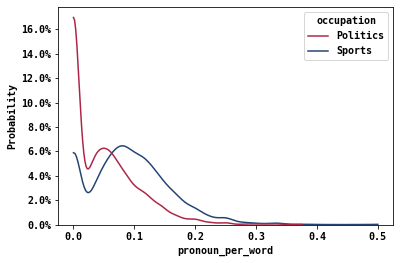

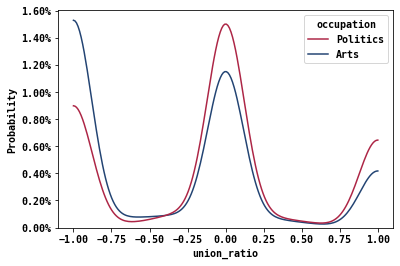

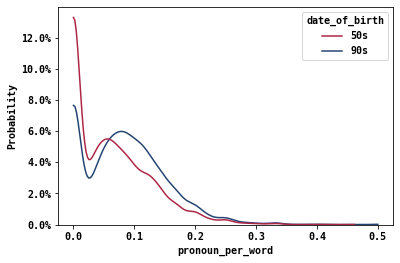

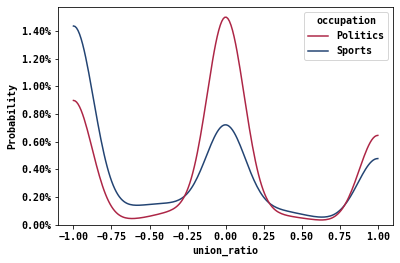

In [158]:
for Significant_list in Most_Significant_list:
    plotDistribution(Test,Significant_list[2],Significant_list[3],binwidth=0.01,include_only=Significant_list[:2])

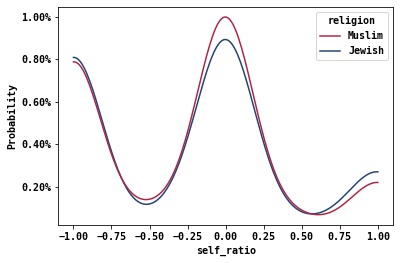

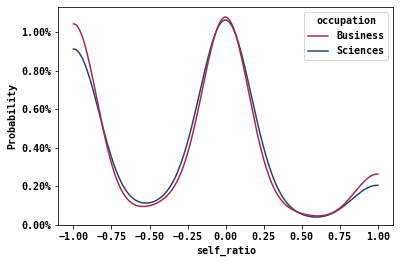

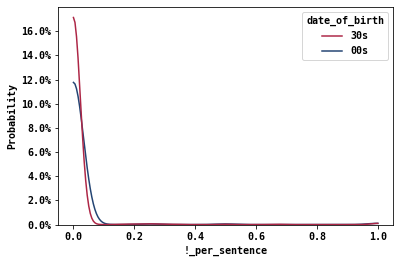

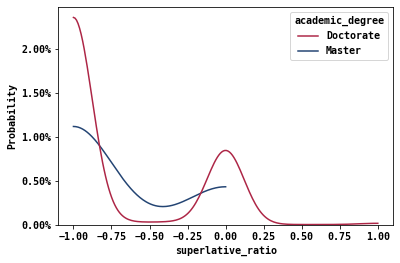

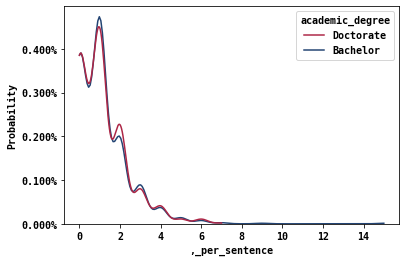

In [169]:
for Significant_list in Least_Significant_list:
    plotDistribution(Test,Significant_list[2],Significant_list[3],binwidth=0.01,include_only=Significant_list[:2])